# Prerequisite and Setup

## Installing all the Packages

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2019-12-22 17:14:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  26.6MB/s    in 55s     

2019-12-22 17:15:14 (26.2 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [2]:
!unzip /content/crawl-300d-2M.vec.zip

Archive:  /content/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
# # installing all the packages

# !pip install -q pandas
# !pip install -q numpy

# !pip install -q scipy
# !pip install -q matplotlib
# !pip install -q seaborn
# !pip install -q wordcloud
# !pip install -q PIL
# !pip install -q Pillow
# !pip install -q matplotlib_venn
# !pip install -q pydot
# !pip install -q graphviz
# !pip install -q IPython.display

# !pip install -q nltk
# !pip install -q collections
# !pip install -q collections-extended
# !pip install -q spacy
# !pip install -q sklearn
# !pip install -q tensorflow
# !pip install -q keras

## Importing all the Packages

In [0]:
# import required packages

import pandas as pd 
import numpy as np
import os, gc, time, warnings
import itertools    

# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
import pydot, graphviz
from IPython.display import Image

import string, re, nltk, collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import lightgbm as lgb
import xgboost as xgb

## Setting up the settings

In [7]:
# settings

os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
ps = PorterStemmer()
tokenizer = TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Importing Dataset

In [0]:
# import the dataset

data = pd.read_csv("/content/all_data.csv",header=None, encoding = 'latin-1')

data['split'] = np.random.randn(data.shape[0], 1)

msk = np.random.rand(len(data)) <= 0.7

train = data[msk]
dev = data[~msk]

# train = pd.read_csv("../input/midasiiitd/V1.4_Training.csv", encoding = 'latin-1')
# dev = pd.read_csv("../input/midasiiitd/SubtaskA_Trial_Test_Labeled.csv", encoding = 'latin-1')
# test = pd.read_csv("../input/midasiiitd/SubtaskA_EvaluationData.csv", encoding = 'latin-1')

# Exploratory Data Analysis

## Training Data

In [9]:
# quick look at a few training examples

train.head(10)

,0,1,split
1,"""Note: in your .csproj file, there is a Suppor...",Normal,-0.654226
2,"""Wich means the new version not fully replaced...",Normal,-0.961381
3,"""Some of my users will still receive the old x...",Normal,1.151093
5,"""My app has a WP7 version and a WP8 version XA...",Normal,-0.567138
6,"""The wp7 xap works only on WP7 and the wp8 xap...",Normal,1.308395
8,"""It should be an option to remove the ""ru"" lan...",Suggestion,1.527926
9,"""Currently if you ever mistakenly selected a ""...",Normal,1.088237
10,"""): the store will randomly deliver the old/wr...",Normal,2.019156
11,"""I write a lot support ticket on this, but no ...",Normal,0.237538
12,"""The engineering team can solve this issue if ...",Normal,-1.722598


In [10]:
print("Training data...")
train.info()

Training data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11751 entries, 1 to 16658
Data columns (total 3 columns):
0        11751 non-null object
1        11751 non-null object
split    11751 non-null float64
dtypes: float64(1), object(2)
memory usage: 367.2+ KB


In [11]:
# class-imbalance in training data

suggestion_count = (train[1].values == 'Suggestion').astype(int).sum()
task_assigned_count = (train[1].values == 'Task Assigned').astype(int).sum()
non_suggestion_count = (train[1].values == 'Normal').astype(int).sum()

print("Stats in training")
print("Total sentences : " + str(train.shape[0]))
print("Total suggestions : " + str(suggestion_count))
print("Total task assigned : " + str(task_assigned_count))
print("Total non_suggestions : " + str(non_suggestion_count))

Stats in training
Total sentences : 11751
Total suggestions : 1772
Total task assigned : 4774
Total non_suggestions : 5205


## Development and Validation Data

In [12]:
# exploring the development/validation data

print("Development Set...")
dev.info()

Development Set...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 16656
Data columns (total 3 columns):
0        4908 non-null object
1        4908 non-null object
split    4908 non-null float64
dtypes: float64(1), object(2)
memory usage: 153.4+ KB


In [13]:
# class-imbalance in development data

suggestion_count = (dev[1].values == 'Suggestion').astype(int).sum()
task_assigned_count = (dev[1].values == 'Task Assigned').astype(int).sum()
non_suggestion_count = (dev[1].values == 'Normal').astype(int).sum()

print("Stats in training")
print("Total sentences : " + str(dev.shape[0]))
print("Total suggestions : " + str(suggestion_count))
print("Total task assigned : " + str(task_assigned_count))
print("Total non_suggestions : " + str(non_suggestion_count))

Stats in training
Total sentences : 4908
Total suggestions : 696
Total task assigned : 1960
Total non_suggestions : 2252


<div><p>There is no class imbalance in the development set.</p></div>

## Word Clouds for the Target Classes

Word clouds are a visual representation of the frequency of occurence of several words and phrases in a corpus. The font size of a word or a phrase appearning in a word cloud is directly proportional to its number of occurences in the corpus.

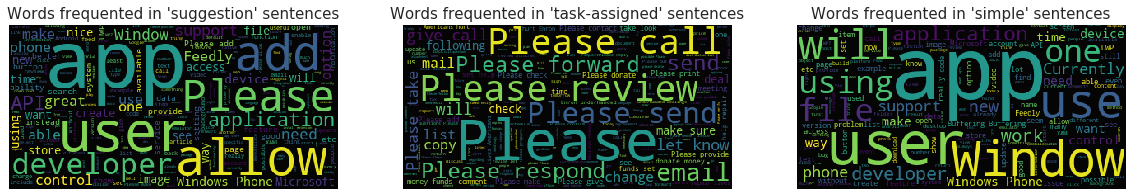

In [14]:
stopword = set(STOPWORDS)

# wordcloud for sentences with 'suggestion' label
subset = train[train[1].values == 'Suggestion']
content = subset[0].values
wc = WordCloud(background_color = "black", max_words = 2000, stopwords = stopword)
wc.generate(" ".join(content))
plt.figure(figsize = (20,20))
plt.subplot(331)
plt.axis("off")
plt.title("Words frequented in 'suggestion' sentences", fontsize = 15)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

# wordcloud for sentences with 'Task Assigned' label
subset = train[train[1].values == 'Task Assigned']
content = subset[0].values
wc = WordCloud(background_color = "black", max_words = 2000, stopwords = stopword)
wc.generate(" ".join(content))
plt.subplot(332)
plt.axis("off")
plt.title("Words frequented in 'task-assigned' sentences", fontsize = 15)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

# wordcloud for sentences with 'Normal' label
subset = train[train[1].values == 'Normal']
content = subset[0].values
wc = WordCloud(background_color = "black", max_words = 2000, stopwords = stopword)
wc.generate(" ".join(content))
plt.subplot(333)
plt.axis("off")
plt.title("Words frequented in 'simple' sentences", fontsize = 15)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

plt.show()

## Top Bigrams in the Target Classes

In [0]:
# Aphost lookup dict

APPO = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying"
}

In [0]:
def clean(sentence):
    sentence = sentence.lower()
    sentence = re.sub('<.*>', '', sentence)
    sentence = re.sub("\\n", "", sentence)
    sentence = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", sentence)
    sentence = re.sub("\[\[.*\]", "", sentence)
    sentence = re.sub("[" + re.sub("\.","",string.punctuation) + "]", "", sentence)
    
    words = tokenizer.tokenize(sentence)
    
    words = [APPO[word] if word in APPO else word for word in words]
    words = [ps.stem(word) for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent = " ".join(words)
    
    return(clean_sent)

In [0]:
# obtaining separate clean corpora for suggestion, task-assigned and normal classes

suggestion_corpus = train[train[1].values == 'Suggestion'][0]
suggestion_corpus = suggestion_corpus.append(dev[dev[1].values == 'Suggestion'][0])
clean_suggestion_corpus = ""
for sentence in suggestion_corpus:
    clean_suggestion_corpus += clean(sentence)

task_assigned_corpus = train[train[1].values == 'Task Assigned'][0]
task_assigned_corpus = task_assigned_corpus.append(dev[dev[1].values == 'Task Assigned'][0])
clean_task_assigned_corpus = ""
for sentence in task_assigned_corpus:
    clean_task_assigned_corpus += clean(sentence)

normal_corpus = train[train[1].values == 'Normal'][0]
normal_corpus = normal_corpus.append(dev[dev[1].values == 'Normal'][0])
clean_normal_corpus = ""
for sentence in normal_corpus:
    clean_normal_corpus += clean(sentence)

### Suggestions


In [18]:
# top 20 bigrams in suggestion sentences

suggestion_bigrams = ngrams(clean_suggestion_corpus.split(), 2)
suggestion_bigrams_freq = collections.Counter(suggestion_bigrams)
suggestion_bigrams_freq.most_common(20)

[(('window', 'phone'), 83),
 (('would', 'like'), 43),
 (('would', 'nice'), 34),
 (('like', 'see'), 33),
 (('would', 'great'), 30),
 (('window', '10'), 26),
 (('like', 'abl'), 22),
 (('allow', 'us'), 18),
 (('someth', 'like'), 16),
 (('allow', 'user'), 16),
 (('dev', 'center'), 15),
 (('app', 'store'), 15),
 (('great', 'could'), 15),
 (('nice', 'abl'), 15),
 (('lock', 'screen'), 13),
 (('window', 'store'), 13),
 (('provid', 'api'), 13),
 (('uwp', 'app'), 13),
 (('allow', 'develop'), 12),
 (('add', 'option'), 12)]

### Task Assigned

In [19]:
# top 20 bigrams in task assigned sentences

task_assigned_bigrams = ngrams(clean_task_assigned_corpus.split(), 2)
task_assigned_bigrams_freq = collections.Counter(task_assigned_bigrams)
task_assigned_bigrams_freq.most_common(20)

[(('let', 'know'), 135),
 (('pleas', 'send'), 126),
 (('pleas', 'call'), 123),
 (('make', 'sure'), 102),
 (('donat', 'thi'), 98),
 (('money', 'fund'), 98),
 (('thi', 'money'), 97),
 (('fund', 'set'), 95),
 (('set', 'help'), 94),
 (('help', 'repair'), 94),
 (('repair', 'live'), 93),
 (('live', 'american'), 93),
 (('american', 'hurt'), 93),
 (('hurt', 'enron'), 93),
 (('enron', 'underhand'), 92),
 (('pleas', 'forward'), 83),
 (('give', 'call'), 83),
 (('review', 'attach'), 79),
 (('could', 'pleas'), 72),
 (('forward', 'thi'), 70)]

### Normal

In [20]:
# top 20 bigrams in normal sentences

normal_bigrams = ngrams(clean_normal_corpus.split(), 2)
normal_bigrams_freq = collections.Counter(normal_bigrams)
normal_bigrams_freq.most_common(20)

[(('window', 'phone'), 180),
 (('window', '10'), 102),
 (('â', '\x80'), 92),
 (('¢', 'â'), 84),
 (('\x80', 'â'), 84),
 (('uwp', 'app'), 51),
 (('app', 'use'), 38),
 (('app', 'store'), 36),
 (('window', 'store'), 35),
 (('app', 'window'), 33),
 (('would', 'allow'), 29),
 (('thi', 'issu'), 27),
 (('win', '10'), 27),
 (('creator', 'updat'), 26),
 (('desktop', 'bridg'), 26),
 (('phone', '8'), 24),
 (('doesnt', 'work'), 24),
 (('would', 'like'), 24),
 (('thi', 'featur'), 24),
 (('phone', '81'), 23)]

In [21]:
del(subset)
del(content)
del(stopword)
del(wc)
del(suggestion_corpus)
del(clean_suggestion_corpus)
del(task_assigned_corpus)
del(clean_task_assigned_corpus)
del(normal_corpus)
del(clean_normal_corpus)
gc.collect()

0

The statistical models cannot learn the syntactic structure of sentences on their own. But, neural networks can. As suggested in paper, we will use Part Of Speech (POS) embeddings to improve the syntactic structure learning by the deep learning models.

## Sentence Length and Target Classes

Finally, let's see how the length of sentences are related to their labels.

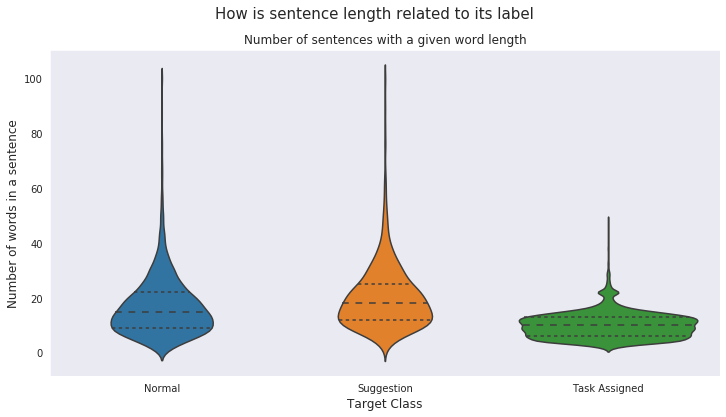

2815

In [22]:
# plot of sentence length against label

df = pd.concat([train, dev])
df['count_word'] = df[0].apply(lambda x : len(x.split()))

plt.figure(figsize = (12, 6))
plt.suptitle("How is sentence length related to its label", fontsize = 15)
count_word = df['count_word'].astype(int)
df['count_word'].loc[df['count_word'] > 100] = 100
plt.plot()
sns.violinplot(y = 'count_word', x = 1, data = df, split = True, inner = "quart")
plt.xlabel('Target Class', fontsize = 12)
plt.ylabel('Number of words in a sentence', fontsize = 12)
plt.title("Number of sentences with a given word length", fontsize = 12)
plt.show()

del(df)
gc.collect()

## Mean Words Length and Target Classes

<div><p>
Another measure that can be checked for is the mean word length. The writers may choose more elegant and longer words for expressing suggestions. 
    </p></div>

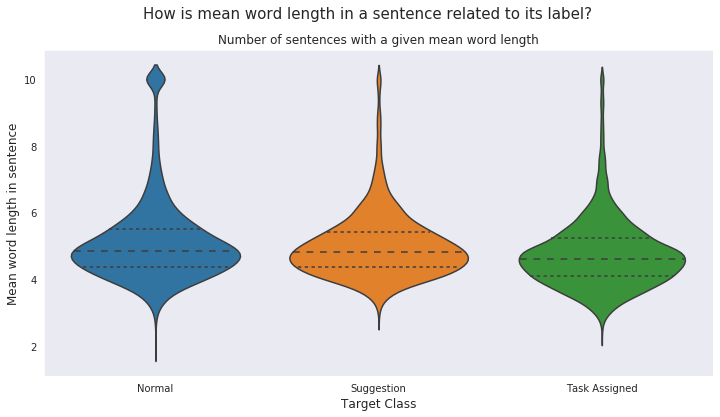

2767

In [23]:
# plot of mean word length against label

df = pd.concat([train, dev])
df['mean_word_len'] = df[0].apply(lambda x : np.mean([len(word) for word in x.split()]))

plt.figure(figsize = (12, 6))
plt.suptitle("How is mean word length in a sentence related to its label?", fontsize = 15)
mean_word_len = df['mean_word_len'].astype(int)
df['mean_word_len'].loc[df['mean_word_len'] > 10] = 10
plt.plot()
sns.violinplot(y = 'mean_word_len', x = 1, data = df, split = True, inner = "quart")
plt.xlabel('Target Class', fontsize = 12)
plt.ylabel('Mean word length in sentence', fontsize = 12)
plt.title("Number of sentences with a given mean word length", fontsize = 12)
plt.show()

del(df)
gc.collect()

# Feature Engineering

We extract certain useful features from the data which may improve the prediction performance of our statistical models.
As is evident from the above analysis, the features related to the frequency of words may not be useful in this particular case. This may be very domain specific, since users on developers' forums are often very concise, less verbose and use more technical terms while writing all kind of sentences.
We need not use these additional features, other than the word embeddings for sequence representation, with deep learning models since the neural networks can learn better feature representations on their own.

In [0]:
# corpus containing all the sentences in train and development data

corpus = (pd.concat([train.iloc[:, 0:2], dev.iloc[:, 0:2]]))[0]
clean_corpus = corpus.apply(lambda x : clean(x))

## Unigram Features

In [0]:
# tf-idf vectors with unigram features

unigram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word', ngram_range = (1,1),
                              sublinear_tf = 1, stop_words = 'english')
unigram_tfv.fit(clean_corpus)

train_unigrams = unigram_tfv.transform(clean_corpus.iloc[:train.shape[0]])
dev_unigrams = unigram_tfv.transform(clean_corpus.iloc[train.shape[0]:train.shape[0]+dev.shape[0]])

## Bigram Features

In [0]:
# tf-idf vectors with bigram and trigram features

btgram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word', ngram_range = (2,3),
            sublinear_tf = 1, stop_words = 'english')
btgram_tfv.fit(clean_corpus)

train_btgrams = btgram_tfv.transform(clean_corpus.iloc[:train.shape[0]])
dev_btgrams = btgram_tfv.transform(clean_corpus.iloc[train.shape[0]:train.shape[0]+dev.shape[0]])

## Ngram Features

In [0]:
# tf-idf vectors with char n-gram features

charngram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'char', ngram_range = (1,5),
                sublinear_tf = 1, stop_words = 'english')
charngram_tfv.fit(clean_corpus)

train_charngrams =  charngram_tfv.transform(clean_corpus.iloc[:train.shape[0]])
dev_charngrams = charngram_tfv.transform(clean_corpus.iloc[train.shape[0]:train.shape[0]+dev.shape[0]])

# Evaluation Metrics

We will use three different evaluation metrics : Precision score, Recall score and F1 score. The F1 score can be interpreted as a weighted average of the Precision and Recall.

In [0]:
# evaluation functions for different models

def lgb_f1_score(preds, train_data):
    y_train = train_data.get_label()
    preds = (preds >= 0.5).astype(int)
    return 'f1_score', f1_score(y_train, preds), True

def xgb_f1_score(preds, train_data):
    y_train = train_data.get_label()
    preds = (preds >= 0.5).astype(int)
    return 'f1_score', f1_score(y_train, preds)

def nn_f1_score(y_true, y_pred):
    y_pred = tf.cast((y_pred >= 0.5), tf.float32)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis = 0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis = 0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis = 0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis = 0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1_score = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1_score)

In [0]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        i = 0
        name = t[0]
        # if not t[1].isdigit():
        #   i = 1
        #   name += " " + t[1]
        classes.append(name)
        v = [float(x) for x in t[i+1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(name)
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [0]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
# dataframes for blending

train_labels = pd.DataFrame()
dev_labels = pd.DataFrame()

# Statistical Models

We will train two statistical models : Logistic Regression and Support Vector Machine (SVM).

In [0]:
# preparing data for statistical and GBDT models

x_train = hstack((train_unigrams, train_btgrams, train_charngrams)).tocsr()
y_train = train[1].values
x_dev = hstack((dev_unigrams, dev_btgrams, dev_charngrams)).tocsr()
y_dev = dev[1].values

In [0]:
def predict_proba(classifier, data):
  result = list()
  for _data in data:
    result.append(np.argmax(classifier.predict_proba(_data)))
  return np.array(result)

In [0]:
def predict(classifier, data):
  result = list()
  for _data in data:
    result.append(np.argmax(classifier.predict(_data)))
  return np.array(result)

In [0]:
def predict(classifier, data, n_tree):
  result = list()
  for _data in data:
    result.append(np.argmax(classifier.predict(_data, ntree_limit = n_tree)))
  return np.array(result)

In [0]:
def get_max(data):
  result = list()
  for _data in data:
    result.append(np.argmax(_data))
  return np.array(result)

In [0]:
def get_mapping(data):
  result = list()
  _dict = ['Normal','Suggestion','Task Assigned']
  for y in data:
    result.append(_dict[y])
  return np.array(result)

In [0]:
def get_mapping1(data):
  result = list()
  _dict = ['Normal','Suggestion','Task Assigned']
  for y in data:
    result.append(_dict[y[0]])
  return np.array(result)

In [0]:
def get_reverse_mapping(data):
  result = list()
  _dict = ['Normal','Suggestion','Task Assigned']
  for y in data:
    result.append(_dict.index(y))
  return np.array(result)

## Logistic Regression Classifier

In [41]:
# logistic regression classifier

# y_train = get_mapping(get_max(y_train))


clf = LogisticRegression(C = 0.1, solver = 'liblinear')
clf.fit(x_train, y_train)

lr_dev_pred = clf.predict(x_dev)

train_labels['lr'] = clf.predict(x_train)
dev_labels['lr'] = lr_dev_pred

y_pred = lr_dev_pred
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

               precision    recall  f1-score   support

       Normal      0.757     0.981     0.855      2252
   Suggestion      0.797     0.085     0.153       696
Task_Assigned      0.960     0.938     0.949      1960

     accuracy                          0.837      4908
    macro avg      0.838     0.668     0.652      4908
 weighted avg      0.844     0.837     0.793      4908



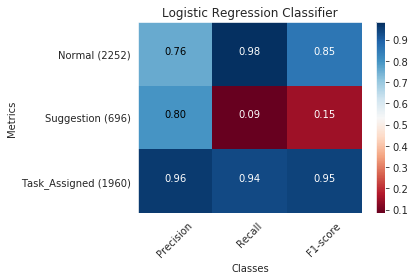

In [42]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('Logistic Regression Classifier')
plt.show()
plt.close()

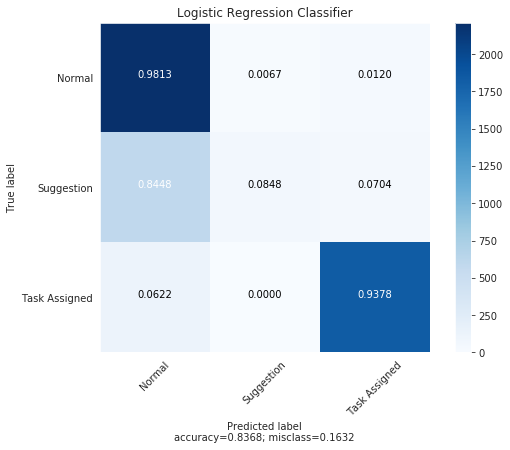

In [43]:
class_names = ['Normal','Suggestion','Task Assigned']

cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, class_names,title='Logistic Regression Classifier')

## Support Vector Machine Classifier

In [44]:
# SVM classifier

# reducing the number of features using Singular Value Decomposition
svd = TruncatedSVD(n_components = 15)
svd.fit(vstack((x_train, x_dev)).tocsr())
x_train_svd = svd.transform(x_train)
x_dev_svd = svd.transform(x_dev)

# scaling the data obtained from SVD
scaler = StandardScaler()
scaler.fit(np.concatenate((x_train_svd, x_dev_svd)))
x_train_svd = scaler.transform(x_train_svd)
x_dev_svd = scaler.transform(x_dev_svd)

clf = SVC(C = 0.1, probability = True)
clf.fit(x_train_svd, y_train)

svm_dev_pred = clf.predict(x_dev_svd)

train_labels['svm'] = clf.predict(x_train_svd)
dev_labels['svm'] = svm_dev_pred

y_pred = svm_dev_pred
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

               precision    recall  f1-score   support

       Normal      0.733     0.968     0.834      2252
   Suggestion      0.700     0.010     0.020       696
Task_Assigned      0.933     0.916     0.925      1960

     accuracy                          0.811      4908
    macro avg      0.789     0.631     0.593      4908
 weighted avg      0.808     0.811     0.755      4908



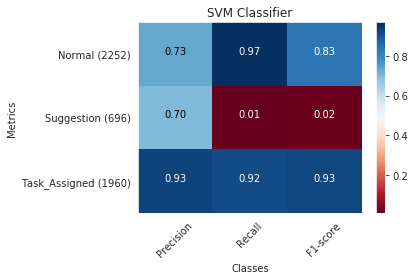

In [45]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('SVM Classifier')
plt.show()
plt.close()

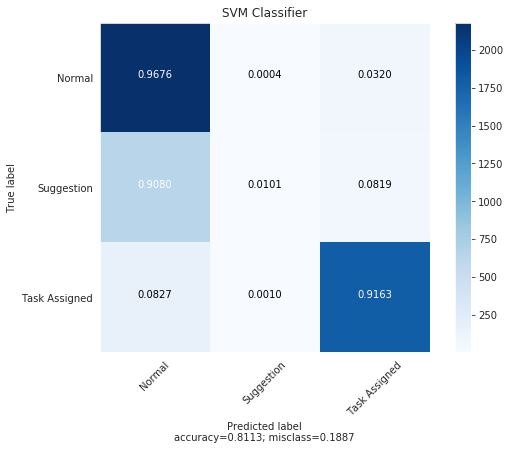

In [46]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, class_names,title='SVM Classifier')

## Gradient Boosting Decision Tree Ensemble Models

<div>
    <h3 id = "gbdtmod">  </h3>
    <p>We will train two high performing GBDT models : LGBM and XGBoost.</p>
</div>

### LightGBM Classifier

In [47]:
# lgbm classifier

d_train = lgb.Dataset(x_train, label = get_reverse_mapping(train[1]))
d_dev = lgb.Dataset(x_dev, label = get_reverse_mapping(dev[1]))
valid_sets = [d_train, d_dev]

params = {
          "objective" : "multiclass",
          'learning_rate': 0.2,
          "num_class" : 3,
          'num_leaves': 31,
          'verbosity': -1,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.6,
          'nthread': 4,
          'lambda_l1': 1,
          'lambda_l2': 1}

# params = {
#           "objective" : "multiclass",
#           "num_class" : 3,
#           "num_leaves" : 60,
#           "max_depth": -1,
#           "learning_rate" : 0.01,
#           "bagging_fraction" : 0.9,  # subsample
#           "feature_fraction" : 0.9,  # colsample_bytree
#           "bagging_freq" : 5,        # subsample_freq
#           "bagging_seed" : 2018,
#           "verbosity" : -1 }


model = lgb.train(params,
                  train_set = d_train,
                  num_boost_round = 25,
                  valid_sets = valid_sets,
                  verbose_eval = 200)

# model = lgb.train(params, d_train, 2000, valid_sets=valid_sets, early_stopping_rounds=100, verbose_eval=200)


lgb_dev_pred = get_mapping(get_max(model.predict(x_dev)))

train_labels['lgb'] = get_mapping(get_max(model.predict(x_train)))
dev_labels['lgb'] = lgb_dev_pred

y_pred = lgb_dev_pred
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

               precision    recall  f1-score   support

       Normal      0.827     0.930     0.876      2252
   Suggestion      0.712     0.422     0.530       696
Task_Assigned      0.950     0.951     0.950      1960

     accuracy                          0.866      4908
    macro avg      0.829     0.768     0.785      4908
 weighted avg      0.860     0.866     0.856      4908



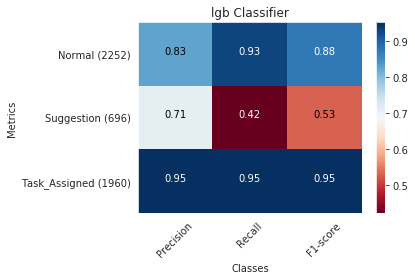

In [48]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('lgb Classifier')
plt.show()
plt.close()

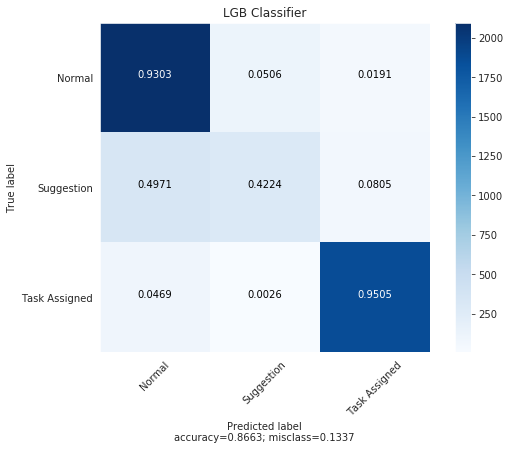

In [49]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, class_names,title='LGB Classifier')

In [50]:
del(d_train)
del(d_dev)
del(model)
gc.collect()

24616

### eXtreme Gradient Boosting Classifier

In [51]:
# XGBoost classifier

d_train = xgb.DMatrix(x_train, label = get_reverse_mapping(y_train))
d_dev = xgb.DMatrix(x_dev, label = get_reverse_mapping(y_dev))
evallist = [(d_train, 'train'), (d_dev, 'valid')]

params = {'booster' : 'gbtree',
          'nthread' : 4,
          'eta' : 0.2,
          'max_depth' : 6,
          'min_child_weight' : 4,
          'subsample' : 0.7,
          'colsample_bytree' : 0.7,
          'objective' : 'multi:softprob',
          'num_class' : 3}

model = xgb.train(params, 
                  d_train, 
                  num_boost_round = 21,
                  evals = evallist,
                  verbose_eval = 200)

xgb_dev_pred = get_mapping(get_max(model.predict(d_dev, ntree_limit=21)))

train_labels['xgb'] = get_mapping(get_max(model.predict(d_train, ntree_limit=21)))
dev_labels['xgb'] = xgb_dev_pred

y_pred = xgb_dev_pred
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

[0]	train-merror:0.169092	valid-merror:0.184189
[20]	train-merror:0.114969	valid-merror:0.148126
               precision    recall  f1-score   support

       Normal      0.800     0.940     0.864      2252
   Suggestion      0.709     0.364     0.481       696
Task_Assigned      0.951     0.924     0.937      1960

     accuracy                          0.852      4908
    macro avg      0.820     0.743     0.761      4908
 weighted avg      0.847     0.852     0.839      4908



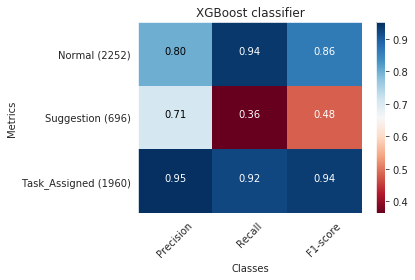

In [52]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('XGBoost classifier')
plt.show()
plt.close()

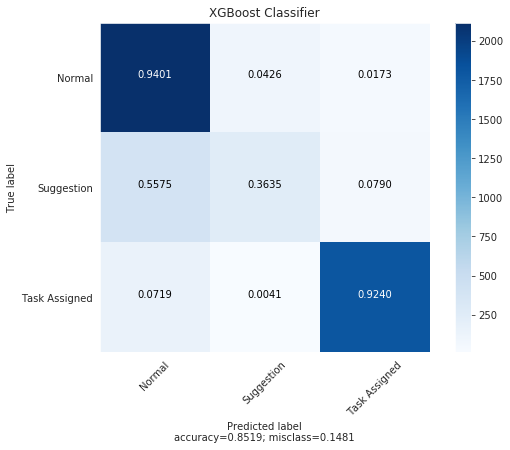

In [53]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, class_names,title='XGBoost Classifier')

In [54]:
del(x_train)
del(y_train)
del(x_dev)
del(y_dev)
del(d_train)
del(d_dev)
del(model)
gc.collect()

8186

# Deep Learning Model

We will develop a hybrid Deep Neural Network architecture containing Gated Recurrent Unit (GRU) units as well as Convolutional layers. The reason we use GRU and not LSTM is that the lengths of word sequences in our dataset are quite small, average length being 19 words. GRU is faster than LSTM and known to perform better with smaller length sequences. In the recent years, Facebook's <a href = "https://www.kaggle.com/facebook/fasttext-wikinews"> fastText </a> library has shown better performance at learning word representation than other pre-trained models. So, we will use this library for generating word embeddings and POS embeddings. 

In [0]:
# preparing data for Neural Network

EMBEDDING_FILE = '/content/crawl-300d-2M.vec'

max_features = 11760
# max_features = 17139
maxlen = 600
embed_size = 300

pos_tags_train = train[0].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values
pos_tags_dev = dev[0].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values

x_train = train[0].values + " " + pos_tags_train
y_train = train[1].values
x_dev = dev[0].values + " " + pos_tags_dev
y_dev = dev[1].values

tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(x_train) + list(x_dev))

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)

x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_dev = sequence.pad_sequences(x_dev, maxlen = maxlen)

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype = 'float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Hybrid Neural Network classifier

In [56]:
# Hybrid Neural Network classifier

y_train = to_categorical(get_reverse_mapping(train[1]), 3)
y_dev = to_categorical(get_reverse_mapping(dev[1]), 3)

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size, weights = [embedding_matrix])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(100, return_sequences = True))(x)
x = Conv1D(50, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(3, activation = "softmax")(conc)
    
model = Model(inputs = inp, outputs = outp)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(x_train, y_train, batch_size = 128, epochs = 15, validation_data = (x_dev, y_dev), verbose = 1)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11751 samples, validate on 4908 samples
Epoch 1/15
11751/11751 [==============================] - 564s 48ms/step - loss: 0.4119 - acc: 0.8384 - val_loss: 0.2501 - val_acc: 0.8957
Epoch 2/15
11751/11751 [==============================] - 558s 47ms/step - loss: 0.2114 - acc: 0.9146 - val_loss: 0.2044 - val_acc: 0.9167
Epoch 3/15
11751/11751 [==============================] - 559s 48ms/step - loss: 0.1518 - acc: 0.9392 - val_loss: 0.1794 - val_acc: 0.9293
Epoch 4/15
11751/11751 [==============================] - 561s 48ms/step - loss: 0.1137 - acc: 0.9554 - val_loss: 0.2054 - val_acc: 0.9262
Epoch 5/15
11751/11751 [==============================] - 563s 48ms/step - loss: 0.0761 - acc: 0.9712 - val_loss: 0.2204 - val_acc: 0.9240
Epoch 6/15
11751/11751 [=========

In [57]:
nn_dev_pred = get_mapping(get_max(model.predict(x_dev, batch_size = 128, verbose = 1)))

train_labels['nn'] = get_mapping(get_max(model.predict(x_train, batch_size = 128, verbose = 1)))
dev_labels['nn'] = nn_dev_pred

y_pred = nn_dev_pred
y_dev = get_mapping(get_max(y_dev))
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

11751/11751 [==============================] - 121s 10ms/step
               precision    recall  f1-score   support

       Normal      0.900     0.932     0.916      2252
   Suggestion      0.763     0.671     0.714       696
Task_Assigned      0.992     0.993     0.993      1960

     accuracy                          0.920      4908
    macro avg      0.885     0.865     0.874      4908
 weighted avg      0.917     0.920     0.918      4908



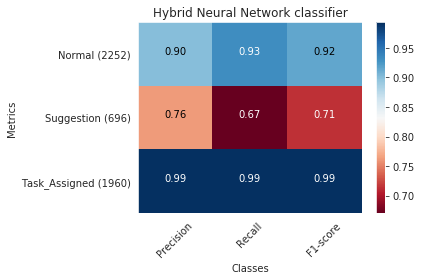

In [58]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('Hybrid Neural Network classifier')
plt.show()
plt.close()

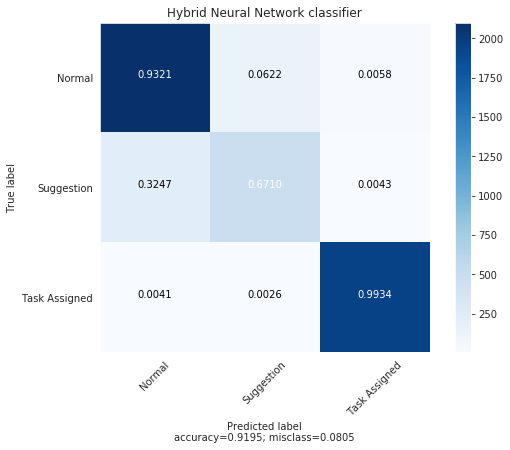

In [59]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, class_names, title = 'Hybrid Neural Network classifier')